In [1]:
using LinearAlgebra, Statistics, Distributions, Test, Plots

import Base: +, *, isequal, ==

using SpinQubits

In [2]:
mutable struct Spinor
    spins::Array{Array{Int}}
    coefficients::Array{Complex}
end

function +(spinorA::Spinor, spinorB::Spinor)
    spinsC = deepcopy(spinorA.spins)
    coefficientsC = deepcopy(spinorA.coefficients)
    for (coeffB,spinB) in zip(spinorB.coefficients,spinorB.spins)
        n = findfirst(isequal(spinB),spinorA.spins)
        if n !== nothing
            coefficientsC[n] += coeffB
        else
            push!(spinsC,spinB)
            push!(coefficientsC,coeffB)
        end
    end
    Spinor(spinsC,coefficientsC)         
end
function *(spinorA::Spinor, spinorB::Spinor)
    result = 0
    for (coeffA,spinA) in zip(spinorA.coefficients,spinorA.spins)
        for (coeffB,spinB) in zip(spinorB.coefficients,spinorB.spins)
            if spinA == spinB
                result += conj(coeffA)*coeffB
            end
        end
    end
    return result
end
function normalize(spinor::Spinor)
    newSpinor = deepcopy(spinor)
    newSpinor.coefficients = spinor.coefficients ./sqrt(spinor*spinor) #spinor on left is already daggered. See *(::Spinor,::Spinor)
    return newSpinor
end
function isequal(spinorA::Spinor, spinorB::Spinor)
    spinorA = normalize(spinorA)
    spinorB = normalize(spinorB)
    return spinorA*spinorB ≈ 1.0
end
==(spinorA::Spinor, spinorB::Spinor) = isequal(spinorA, spinorB)

*(α::Any, spinorB::Spinor) = Spinor(spinorB.spins,α.*spinorB.coefficients)
*(spinorB::Spinor, α::Any) = α*spinorB

function getInitKet(L,singlet)
    if singlet
        initialSpinor = Spinor([[[1,0]; ones(Int64,L-2)]],[1/sqrt(2)]) + Spinor([[[0,1]; ones(Int64,L-2)]],[-1/sqrt(2)])
    else
        initialSpinor = Spinor([[[0]; ones(Int64,L-1)]],[1.0])
    end

    basis = [Spinor([(reverse(digits(i, base=2, pad=L)))],[1.0]) for i in 0:2^L-1]

    initKet = [initialSpinor] .* basis

    return initKet
end

getInitKet (generic function with 1 method)

In [66]:
function σx(n::Int,spinor::Spinor)
    newspinor = deepcopy(spinor)
    for state in newspinor.spins
        state[n] = (state[n] + 1) % 2
    end
    return newspinor
end

function σy(n::Int,spinor::Spinor)
    newspinor = deepcopy(spinor)
    for (i,state) in enumerate(newspinor.spins)
        state[n] = (state[n] + 1) % 2
        newspinor.coefficients[i] *= spinor.spins[i][n] == 1 ? im : -im
    end
    return newspinor
end

function σz(n::Int,spinor::Spinor)
    newspinor = deepcopy(spinor)
    for i in 1:length(newspinor.coefficients)
        newspinor.coefficients[i] *= ((spinor.spins[i][n] == 1) ? 1 : -1)
    end
    return newspinor
end

σiσj(i,j,spinor::Spinor) = #=σx(i,σx(j, spinor)) + σy(i,σy(j, spinor)) + =#σz(i,σz(j, spinor))


σiσj (generic function with 1 method)

In [67]:
spinor1 = Spinor([[1,0,0]],[1.0])

Spinor(Array{Int64, N} where N[[1, 0, 0]], Complex[1.0 + 0.0im])

In [68]:
getBasis(L) = [Spinor([(reverse(digits(i, base=2, pad=L)))],[1]) for i in 0:2^L-1]

function operatorToMatrix(operator, basis)
    mat = zeros(length(basis),length(basis))
    for (i,spinorI) in enumerate(basis)
        for (j,spinorJ) in enumerate(basis)
                    mat[i, j] = (spinorI*operator(spinorJ))
        end
    end
    return mat
end
function operatorToMatrix!(mat, operator, basis)
    for (i,spinorI) in enumerate(basis)
        for (j,spinorJ) in enumerate(basis)
                    mat[i, j] = (spinorI*operator(spinorJ))
        end
    end
end
function getJtensor(L,β; betaArray=[])
    betas = betaArray == [] ? [β^i for i in 0:L-2] : betaArray
    length(betas) != L-1 ? error("betaArray is wrong length.") : nothing

    jTensor = zeros(2^L, 2^L, Int(L*(L-1)/2))
    basis = getBasis(L)
    baseIndex = 0
    @views for k in 1:L-1
        for n in 1:L-k
            operatorToMatrix!(jTensor[:,:,baseIndex + n], x->betas[k]*σiσj(n,n+k,x), basis)
        end
        baseIndex += L-k
    end
    return jTensor
end
function getHtensor(L)
    hTensor = zeros(2^L, 2^L, L)
    basis = getBasis(L)
    @views for n in 1:L
            operatorToMatrix!(hTensor[:,:,n], x->σz(n,x), basis)

    end
    return hTensor
end
function levelspacing(vals)
    diffs = zeros(length(vals)-1)
    rats = zeros(length(vals)-2)
    for i in 1:length(vals)-1
        diffs[i] = vals[i+1] - vals[i]
    end
    for i in 1:length(diffs)-1
        rats[i] = min(diffs[i],diffs[i+1])/max(diffs[i],diffs[i+1])
    end
    return mean(rats)
end

levelspacing (generic function with 1 method)

In [73]:
function getlevelspacingrat(L, sigH, sigJ)
    niters = 1000
    hs = zeros(niters, L)
    for i in eachindex(hs)
        hs[i] = rand(Normal(0.0, sigH))
    end

    js = zeros(niters, Int(L*(L-1)/2))
    for i in eachindex(js)
        js[i] = rand(Normal(1.0, sigJ))
    end

    jTensor = getJtensor(L, 0.0)
    hTensor = getHtensor(L);
    #getHtensor(3)
    spac = zeros(niters)
    for iteration in 1:niters
        Hj = zeros(2^L,2^L)
        Hh = zeros(2^L,2^L)

        for j in 1:Int(L*(L-1)/2)
            Hj .= Hj .+ (js[iteration,j] .* @view jTensor[:,:,j])
        end
        for j in 1:L
            Hh .= Hh .+ hs[iteration,j] .* @view hTensor[:,:,j]
        end
        Hmat = Hj + Hh
        vals = eigvals(Hmat)
        #println(vals)
        spac[iteration] = levelspacing(vals)
    end
    return mean(spac)
end

getlevelspacingrat (generic function with 1 method)

In [74]:
xRange = 10 .^ collect(range(-2,2;step=0.02))

L2 = (xRange,getlevelspacingrat.(2, xRange, xRange[51]))
println("Finished 2nd")
L3 = (xRange,getlevelspacingrat.(3, xRange, xRange[51]))
println("Finished 3rd")
L4 = (xRange,getlevelspacingrat.(4, xRange, xRange[51]))
println("Finished 4th")
#L5 = (xRange,getlevelspacingrat.(5, xRange, xRange[51]))
#println("Finished 5th")

Finished 2nd
Finished 3rd
Finished 4th


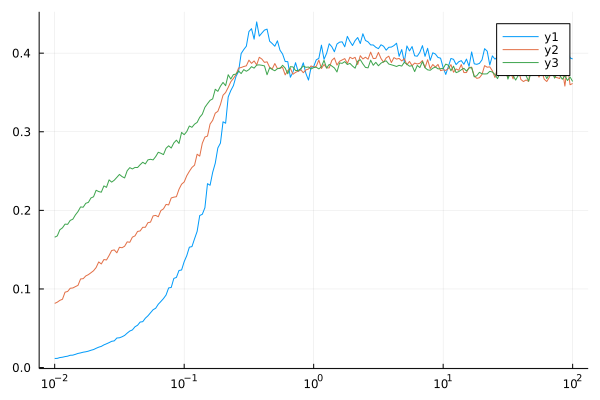

In [75]:
plot( L2, xscale=:log10)
plot!(L3)
plot!(L4)

In [32]:
xRange[51]

0.1